### Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import re
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

### reading a csv file and dispalying first 10 instances

In [2]:
data=pd.read_csv(r"C:\Users\abhim\OneDrive\Desktop\big_dataset.csv")
data.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info,Label
0,598449,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
1,598450,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
2,598451,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
3,598452,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
4,598453,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
5,598454,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
6,598455,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
7,598456,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
8,598457,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now
9,598458,27:46.1,112.217.128.200,10.215.173.1,UDP,1332,19148 > 49005 Len=1304,GeForce_Now


### Extracting source and destination port number from info and converting ip address to decimal and time to seconds and creating a new dataframe named 'df' with all the modified features values


In [3]:
df=pd.DataFrame()

In [4]:
def parse_custom_timestamp(time_str):
    minutes,seconds=time_str.split(':')
    seconds,milliseconds=seconds.split('.')
    td=timedelta(minutes=int(minutes),seconds=int(seconds), milliseconds=int(milliseconds) * 10)
    return td.total_seconds()

In [5]:
def convert_ip_decimal(item):
    source_ip=[]
    for ip in item:
        parts = ip.split('.')
        decimal = (int(parts[0]) * 256**3) + (int(parts[1]) * 256**2) + (int(parts[2]) * 256**1) + (int(parts[3]) * 256**0)
        source_ip.append(decimal)
    return source_ip

In [6]:
source_ports=[]
dest_ports=[]
for item in data['Info']:
    ports = re.findall(r'(\d+)\s+>\s+(\d+)', str(item))
    if ports:
        source_port, dest_port = ports[0]
        source_ports.append(int(source_port))
        dest_ports.append(int(dest_port))
        prev1_port=int(source_port)
        prev2_port=int(dest_port)
    else:
        # If no port numbers are found, append NaN
        source_ports.append(int(prev1_port))
        dest_ports.append(int(dest_port))

In [7]:
df["Time_seconds"] = data["Time"].apply(parse_custom_timestamp)
df["source_ip"]=convert_ip_decimal(data["Source"])
df["destination_ip"]=convert_ip_decimal(data["Destination"])
df["protocol"]=data["Protocol"]
df["length"]=data["Length"]
df['source_port_number']=source_ports
df['destination_port_number']=dest_ports
df['label']=data['Label']

In [8]:
df.head(10)

,Time_seconds,source_ip,destination_ip,protocol,length,source_port_number,destination_port_number,label
0,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
1,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
2,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
3,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
4,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
5,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
6,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
7,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
8,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now
9,1666.01,1893302472,181906689,UDP,1332,19148,49005,GeForce_Now


In [9]:
df.shape

(933729, 8)

In [10]:
print(f"Time={df['Time_seconds'].isnull().sum()}")
print(f"source ip={df['source_ip'].isnull().sum()}")
print(f"destination ip={df['destination_ip'].isnull().sum()}")
print(f"protocol={df['protocol'].isnull().sum()}")
print(f"length={df['length'].isnull().sum()}")
print(f"source port no={df['source_port_number'].isnull().sum()}")
print(f"destination port no={df['destination_port_number'].isnull().sum()}")

Time=0
source ip=0
destination ip=0
protocol=0
length=0
source port no=0
destination port no=0


### Identifying and removing outliers

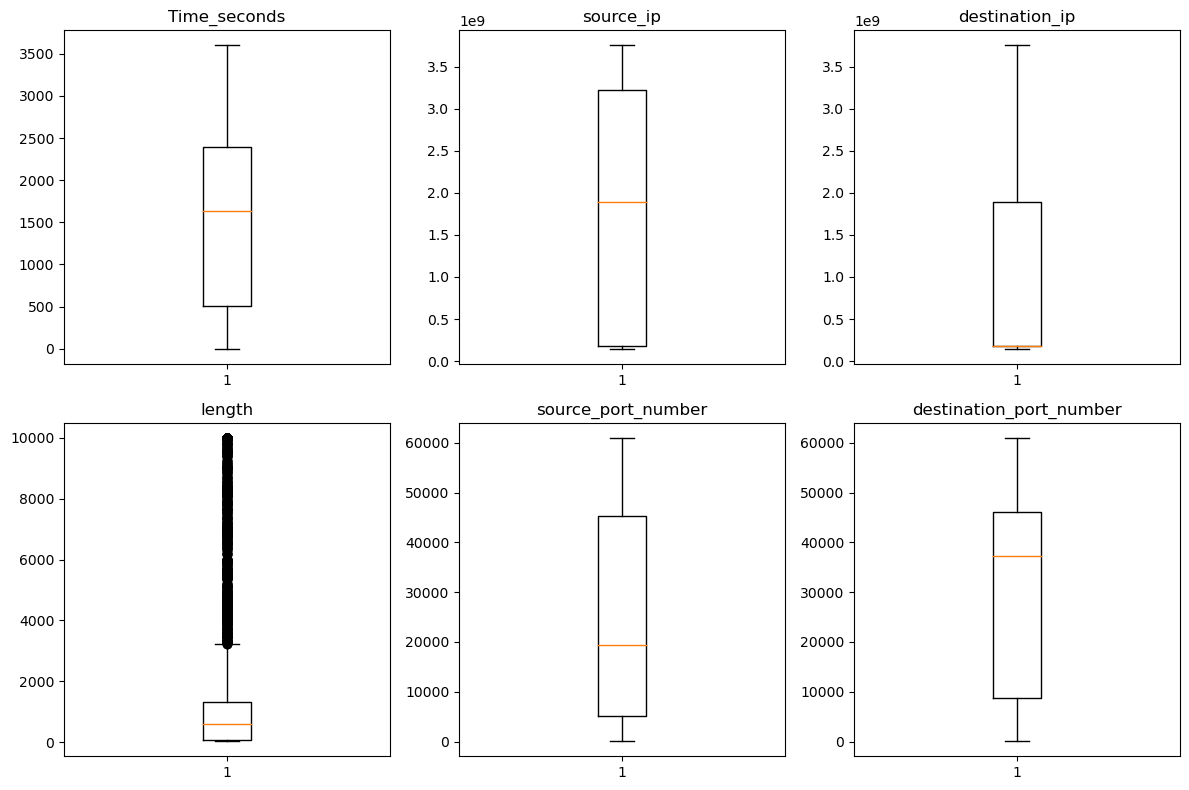

Outliers before removal:
Column: Time_seconds, Number of outliers: 0
Column: source_ip, Number of outliers: 0
Column: destination_ip, Number of outliers: 0
Column: length, Number of outliers: 7794
Column: source_port_number, Number of outliers: 0
Column: destination_port_number, Number of outliers: 0


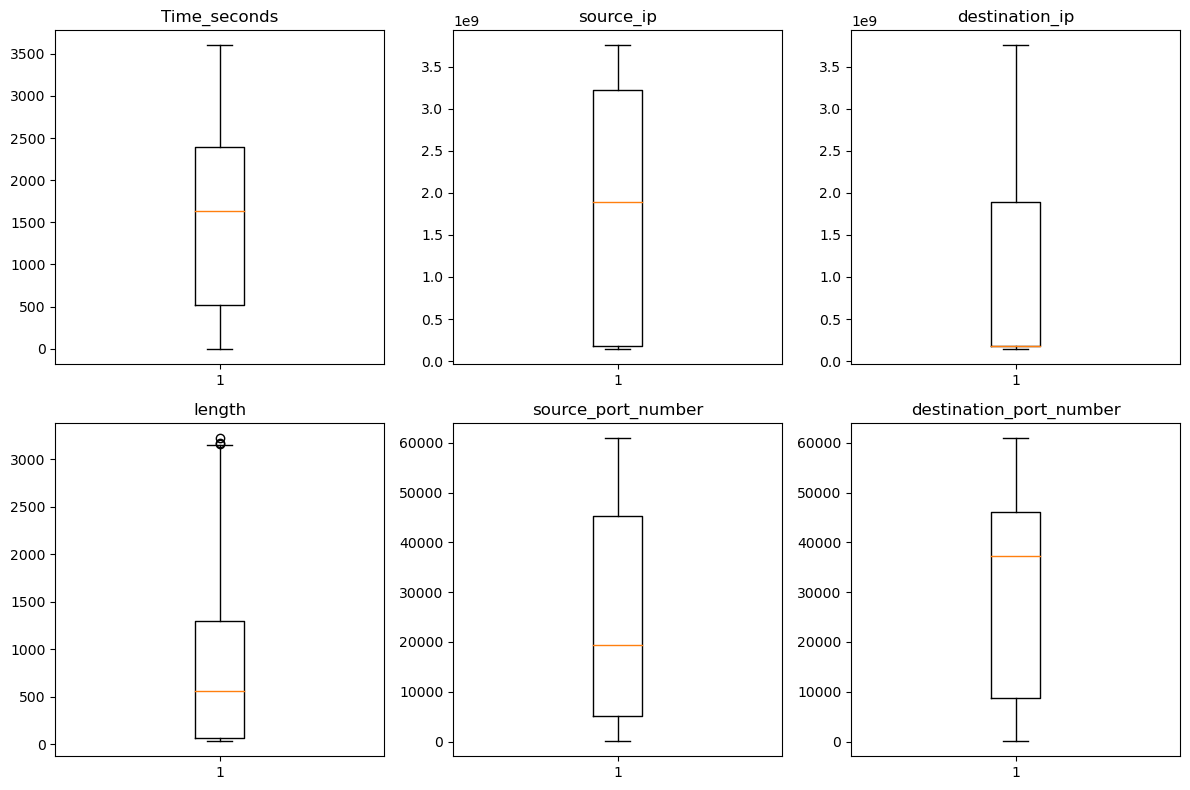

In [11]:
# Function to identify outliers using IQR
def identify_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Select the numerical columns you want to check for outliers
numerical_columns = ['Time_seconds', 'source_ip', 'destination_ip', 'length', 'source_port_number', 'destination_port_number']

# Plot box plots to visualize outliers before removal
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

# Identify and print outliers before removal
print("Outliers before removal:")
for column in numerical_columns:
    outliers = identify_outliers_iqr(df, column)
    print(f"Column: {column}, Number of outliers: {len(outliers)}")

# Remove outliers
for column in numerical_columns:
    df = remove_outliers_iqr(df, column)

# Plot box plots to visualize data after removal of outliers
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [12]:
# Print DataFrame after removing outliers
print("DataFrame shape after removing outliers:")
print(df.shape)

DataFrame shape after removing outliers:
(925935, 8)


### Normalizing and encoding a data

In [13]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming 'df' is your DataFrame with the dataset

# # Plot histograms and kernel density plots for each numerical feature
# plt.figure(figsize=(12, 8))
# for i, column in enumerate(df.columns, 1):
#     plt.subplot(3, 3, i)
#     sns.histplot(df[column], kde=True)  # Plot histogram with kernel density estimation
#     plt.title(column)
# plt.tight_layout()
# plt.show()

In [14]:
df=df.drop_duplicates()
print("size after removing duplicates :",df.shape)

size after removing duplicates : (366132, 8)


In [15]:
# columns=["Time_seconds","source_ip","destination_ip","length","source_port_number","destination_port_number"]

# scaler=StandardScaler()
# scaler.fit(df[columns])
# scaled_values=scaler.transform(df[columns])

# protocol_encoder=LabelEncoder()
# label_encoder=LabelEncoder()

# protocol_encoder.fit(df["protocol"])
# df["protocol"]=protocol_encoder.transform(df["protocol"])

# df.dropna(subset=['label'], inplace=True)

# label_encoder.fit(df["label"])
# df["label"]=label_encoder.transform(df["label"])

In [16]:
# Check initial length of the DataFrame
initial_length = len(df)
print(f"Initial length of df: {initial_length}")

columns = ["Time_seconds", "source_ip", "destination_ip", "length", "source_port_number", "destination_port_number"]

# Scale the specified columns
scaler = StandardScaler()
scaler.fit(df[columns])
scaled_values = scaler.transform(df[columns])

# Encode 'protocol' column
protocol_encoder = LabelEncoder()
protocol_encoder.fit(df["protocol"])
df["protocol"] = protocol_encoder.transform(df["protocol"])

# Check length before dropping NA values in 'label'
before_drop_length = len(df)
print(f"Length before dropping NA in 'label': {before_drop_length}")

# Drop rows where 'label' is NA
df.dropna(subset=['label'], inplace=True)

# Check length after dropping NA values in 'label'
after_drop_length = len(df)
print(f"Length after dropping NA in 'label': {after_drop_length}")

# Encode 'label' column
label_encoder = LabelEncoder()
label_encoder.fit(df["label"])
df["label"] = label_encoder.transform(df["label"])

# Ensure scaled_values has the same length as df after dropping rows
scaled_values = scaled_values[:len(df)]

# Assign scaled values back to DataFrame
df[columns] = scaled_values


Initial length of df: 366132
Length before dropping NA in 'label': 366132
Length after dropping NA in 'label': 366130


In [17]:
df.head(10)

,Time_seconds,source_ip,destination_ip,protocol,length,source_port_number,destination_port_number,label
0,0.065499,0.221490,-0.714814,23,2.329723,-0.293983,0.945408,2
11,0.065499,0.221490,-0.714814,23,0.694048,-0.293983,0.945408,2
14,0.065499,0.221490,-0.714814,23,-0.041060,-0.589463,0.945308,2
37,0.065499,0.221490,-0.714814,23,0.691684,-0.293983,0.945408,2
40,0.065499,-1.003527,0.667470,23,-0.494889,1.156025,-0.516378,2
44,0.065499,0.221490,-0.714814,23,-0.012696,-0.589463,0.945308,2
46,0.065499,0.221490,-0.714814,23,-0.728895,-0.313458,0.945458,2
72,0.065499,0.221490,-0.714814,23,0.580591,-0.293983,0.945408,2
73,0.065509,0.221490,-0.714814,23,-0.041060,-0.589463,0.945308,2
75,0.065509,0.221490,-0.714814,23,-0.012696,-0.589463,0.945308,2


In [18]:
protocol_mapping = dict(zip(protocol_encoder.classes_, protocol_encoder.transform(protocol_encoder.classes_)))
print("protocol Mapping:", protocol_mapping)

protocol Mapping: {'CLTP': 0, 'DB-LSP': 1, 'DCP-AF': 2, 'DCP-PFT': 3, 'DNS': 4, 'ENIP': 5, 'HTTP': 6, 'HTTP/JSON': 7, 'MPEG TS': 8, 'NXP 802.15.4 SNIFFER': 9, 'Pathport': 10, 'QUIC': 11, 'R-GOOSE': 12, 'RTCP': 13, 'RakNet': 14, 'SSL': 15, 'SSLv2': 16, 'STUN': 17, 'TCP': 18, 'THRIFT': 19, 'TLSv1': 20, 'TLSv1.2': 21, 'TLSv1.3': 22, 'UDP': 23, 'WireGuard': 24}


In [19]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("label Mapping:", label_mapping)

label Mapping: {'Afreeca_TV': 0, 'BattleGround': 1, 'GeForce_Now': 2, 'Google_Meet': 3, 'KT_GameBox': 4, 'MS_Teams': 5, 'Naver_Now': 6, 'Netflix': 7, 'Roblox': 8, 'TeamFight_Tactics': 9, 'YouTube': 10, 'YouTube_Live': 11, 'Zepto': 12, 'Zoom': 13}


In [20]:
X=df.iloc[:,:-1]
Y=df["label"]
print(X.shape)

(366130, 7)


### Feature selection

#### using extra tree classifier

[0.12583771 0.19157538 0.15941894 0.10061159 0.04693797 0.19456411
 0.1810543 ]
Time_seconds               0.125838
source_ip                  0.191575
destination_ip             0.159419
protocol                   0.100612
length                     0.046938
source_port_number         0.194564
destination_port_number    0.181054
dtype: float64


<Axes: >

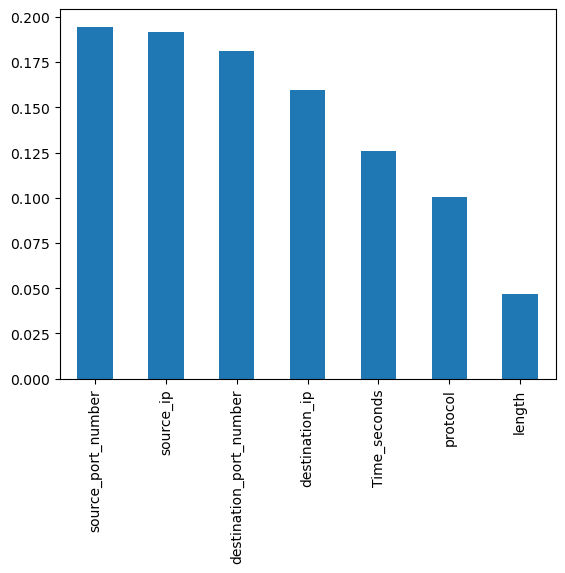

In [21]:
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

# Create a pandas Series for feature importances:
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
print(feat_importance)

# Plotting the largest 7 feature importances
feat_importance.nlargest(7).plot(kind='bar')

#### using corelation matrix

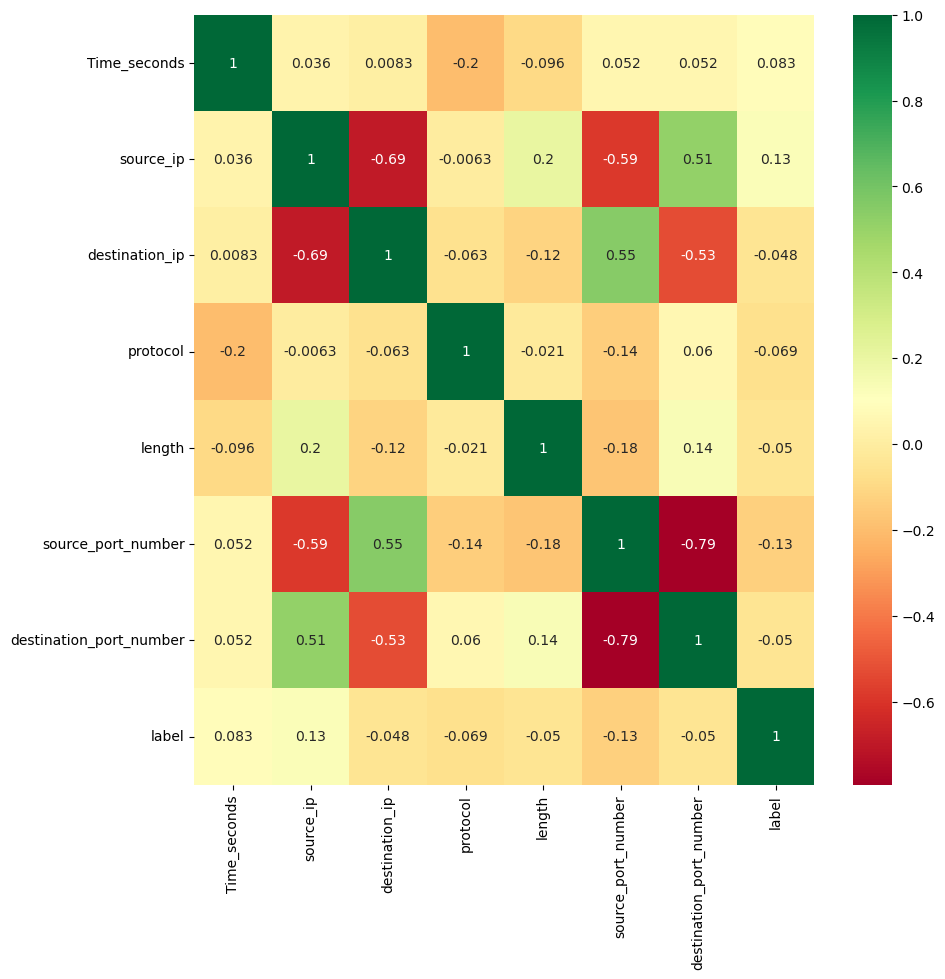

In [22]:
corrmat = df.corr()

# Plot the heatmap using seaborn
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, annot=True, cmap='RdYlGn')
plt.show()

#### using recursive fuction elimination

In [23]:
model = RandomForestClassifier(random_state=0)

# Initialize RFE with the model, requesting half of the features to be selected
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust n_features_to_select as needed
rfe.fit(X, Y)

# Summary of feature selection
selected_features_rfe = X.columns[rfe.support_].tolist()

print("Selected features based on Recursive Feature Elimination (RFE):", selected_features_rfe)


Selected features based on Recursive Feature Elimination (RFE): ['Time_seconds', 'source_ip', 'protocol', 'source_port_number', 'destination_port_number']


#### using Annova

In [24]:
# Initialize SelectKBest with f_classif as the score function
best_features_anova = SelectKBest(score_func=f_classif, k=7)

# Assume X and y are already defined; fit the model
fit_anova = best_features_anova.fit(X, Y)

# Create DataFrame for scores and feature names
df_scores_anova = pd.DataFrame(fit_anova.scores_)
df_columns_anova = pd.DataFrame(X.columns)

# Concatenate DataFrames for feature names and their corresponding scores
feature_scores_anova = pd.concat([df_columns_anova, df_scores_anova], axis=1)
feature_scores_anova.columns = ["Specs", "Score"]  # Make sure column names are correctly assigned

# Print the top 7 features with the highest ANOVA F-values
top_features_anova = feature_scores_anova.nlargest(7, 'Score')
print(top_features_anova.sort_values(by='Score', ascending=False))


                     Specs         Score
3                 protocol  50261.012680
0             Time_seconds  16226.632909
4                   length  12938.500538
1                source_ip   8370.980551
5       source_port_number   6328.642724
6  destination_port_number   4757.000394
2           destination_ip   2911.508643


In [25]:
imp_features=["Time_seconds","source_ip","destination_ip","source_port_number","destination_port_number"]

In [26]:
df1 = shuffle(df, random_state=0)

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=0)
print(y_train.value_counts())
print(X_train.shape)
print(X_test.shape)

12    56830
1     46143
11    44132
9     37102
3     26386
5     25747
13    14691
8     10692
0     10285
2      6634
4      5036
7      4978
6      2936
10     1312
Name: label, dtype: int64
(292904, 7)
(73226, 7)


### balancing the classes using SMOTE (Synthetic Minority Over-sampling Technique)

In [27]:
# Applying SMOTE
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [28]:
y_train_resampled.value_counts()

3     56830
8     56830
11    56830
13    56830
9     56830
1     56830
4     56830
12    56830
2     56830
7     56830
0     56830
5     56830
6     56830
10    56830
Name: label, dtype: int64

### Decision Tree model

In [29]:
dt_classifier = DecisionTreeClassifier(max_depth=8, min_samples_split=50, min_samples_leaf=25)
cv_scores = cross_val_score(dt_classifier, X_train_resampled, y_train_resampled, cv=5)
print("Adjusted CV average score: {:.2f}".format(cv_scores.mean()))

Adjusted CV average score: 0.98


In [30]:
dt_classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=25, min_samples_split=50)

In [31]:
y_pred_resampled=dt_classifier.predict(X_train_resampled)
y_pred = dt_classifier.predict(X_test)
print(X_train_resampled.shape)

(795620, 7)


In [32]:
# Accuracy
print("train accuracy",accuracy_score(y_pred_resampled, y_train_resampled))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# # More detailed report
print(classification_report(y_test, y_pred))

train accuracy 0.9833802569065634
Test Accuracy: 0.9688771747739874
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2620
           1       0.96      0.95      0.96     11653
           2       0.82      1.00      0.90      1693
           3       1.00      0.99      0.99      6490
           4       1.00      0.99      1.00      1174
           5       1.00      0.92      0.96      6332
           6       0.99      1.00      1.00       739
           7       0.90      1.00      0.95      1152
           8       1.00      1.00      1.00      2589
           9       0.90      0.98      0.94      9226
          10       1.00      1.00      1.00       319
          11       1.00      1.00      1.00     11111
          12       0.98      0.93      0.95     14419
          13       1.00      1.00      1.00      3709

    accuracy                           0.97     73226
   macro avg       0.97      0.98      0.97     73226
weighted avg

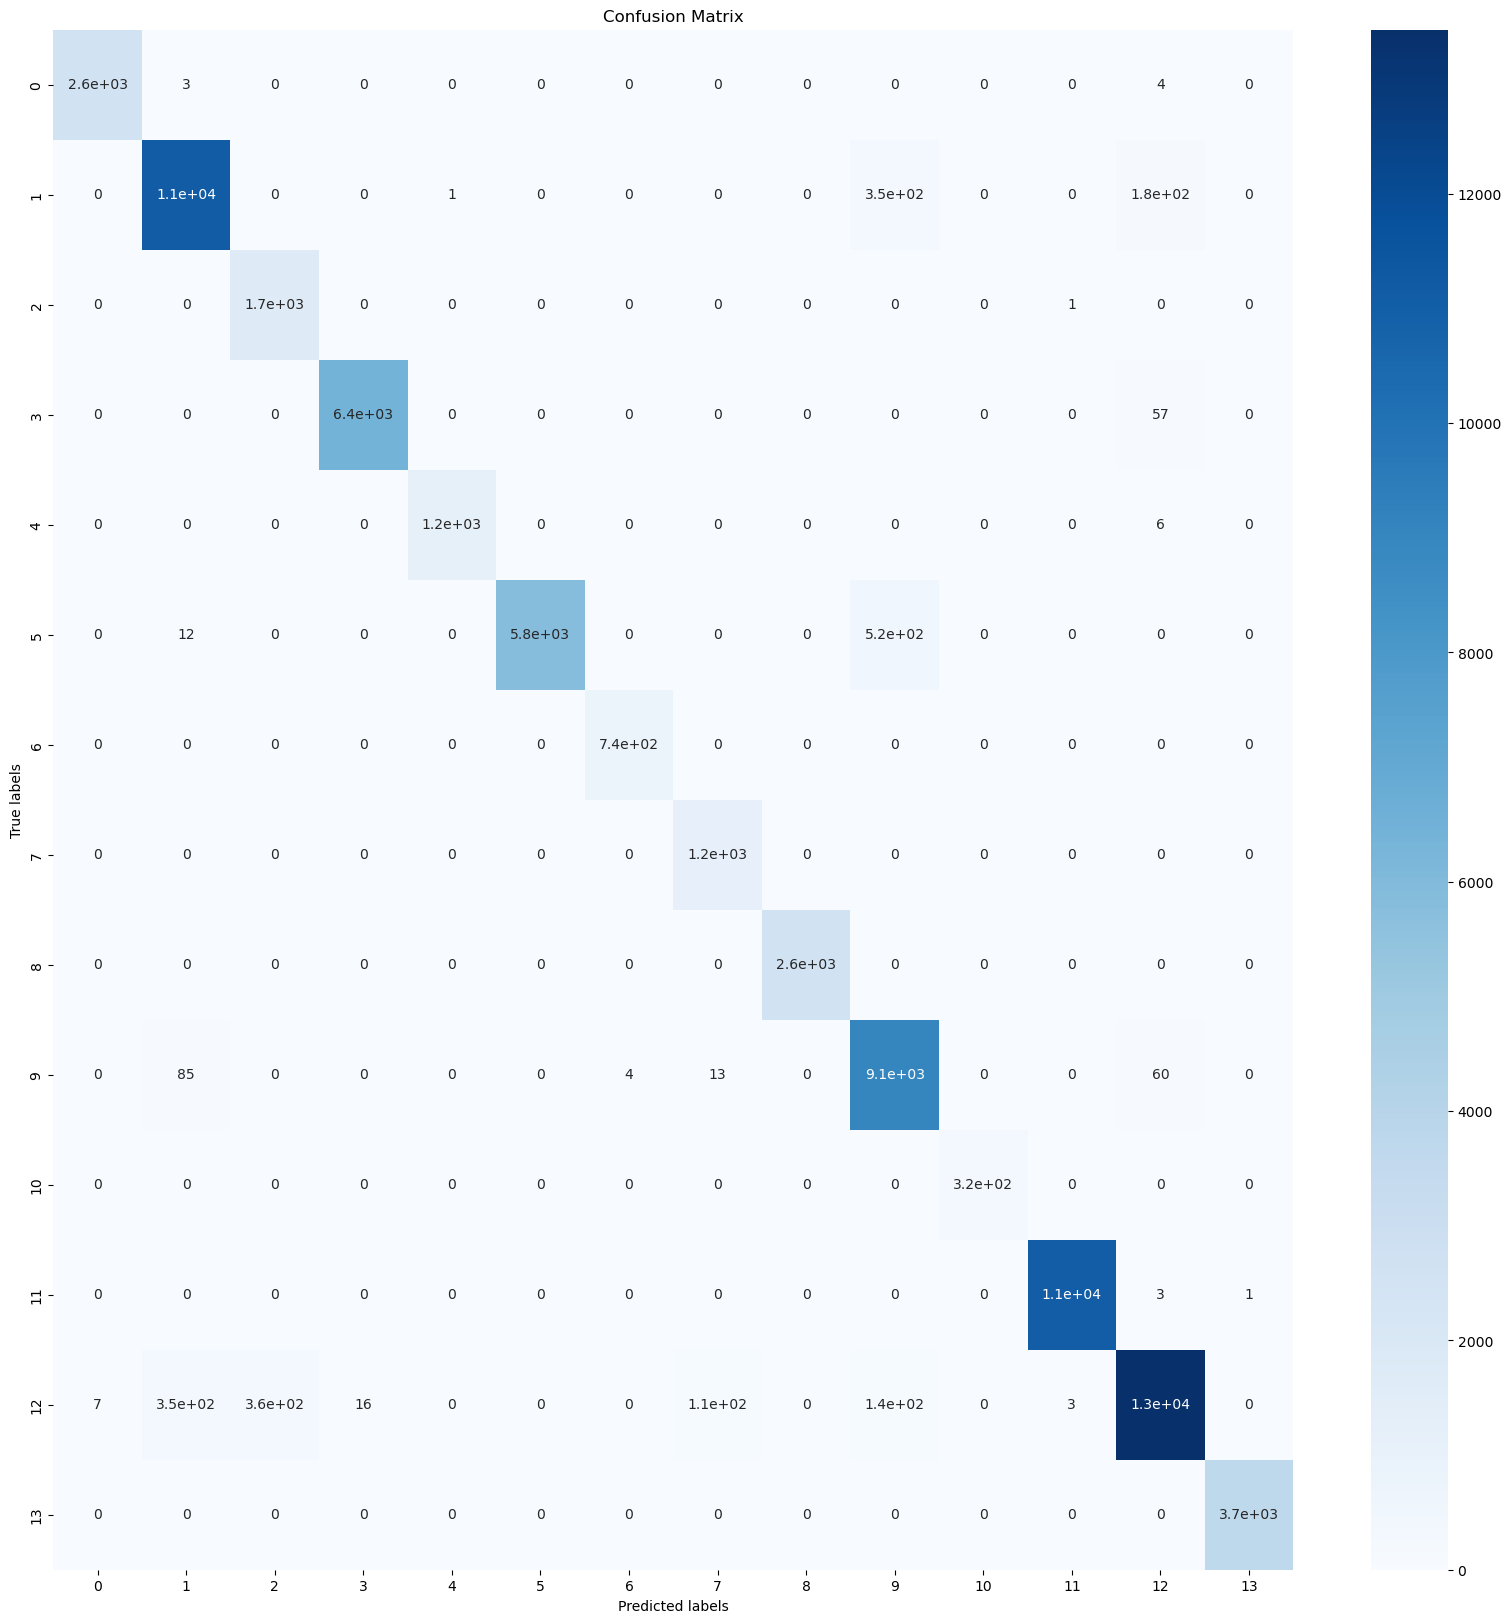

In [33]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')  # You can change the color scheme here
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Random forest classifier model

In [34]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
# Perform cross-validation for each classifier
rf_cv_scores = cross_val_score(rf_classifier, X_train_resampled, y_train_resampled, cv=5)

# Print average CV scores
print("Random Forest CV average score: {:.2f}".format(rf_cv_scores.mean()))

Random Forest CV average score: 1.00


In [35]:
# Fit the random forest classifier to the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=0)

In [36]:
# Predictions on the resampled training data
y_pred_resampled_rf = rf_classifier.predict(X_train_resampled)

# Predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Compute accuracy for the random forest classifier
train_accuracy_rf = accuracy_score(y_pred_resampled_rf, y_train_resampled)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("\nRandom Forest Classifier")
print("Train Accuracy:", train_accuracy_rf)
print("Test Accuracy:", test_accuracy_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier
Train Accuracy: 1.0
Test Accuracy: 0.9998361237811706

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2620
           1       1.00      1.00      1.00     11653
           2       1.00      1.00      1.00      1693
           3       1.00      1.00      1.00      6490
           4       1.00      1.00      1.00      1174
           5       1.00      1.00      1.00      6332
           6       1.00      1.00      1.00       739
           7       1.00      1.00      1.00      1152
           8       1.00      1.00      1.00      2589
           9       1.00      1.00      1.00      9226
          10       1.00      1.00      1.00       319
          11       1.00      1.00      1.00     11111
          12       1.00      1.00      1.00     14419
          13       1.00      1.00      1.00      3709

    accuracy                           1.00     73226
   macro avg       1.00      1

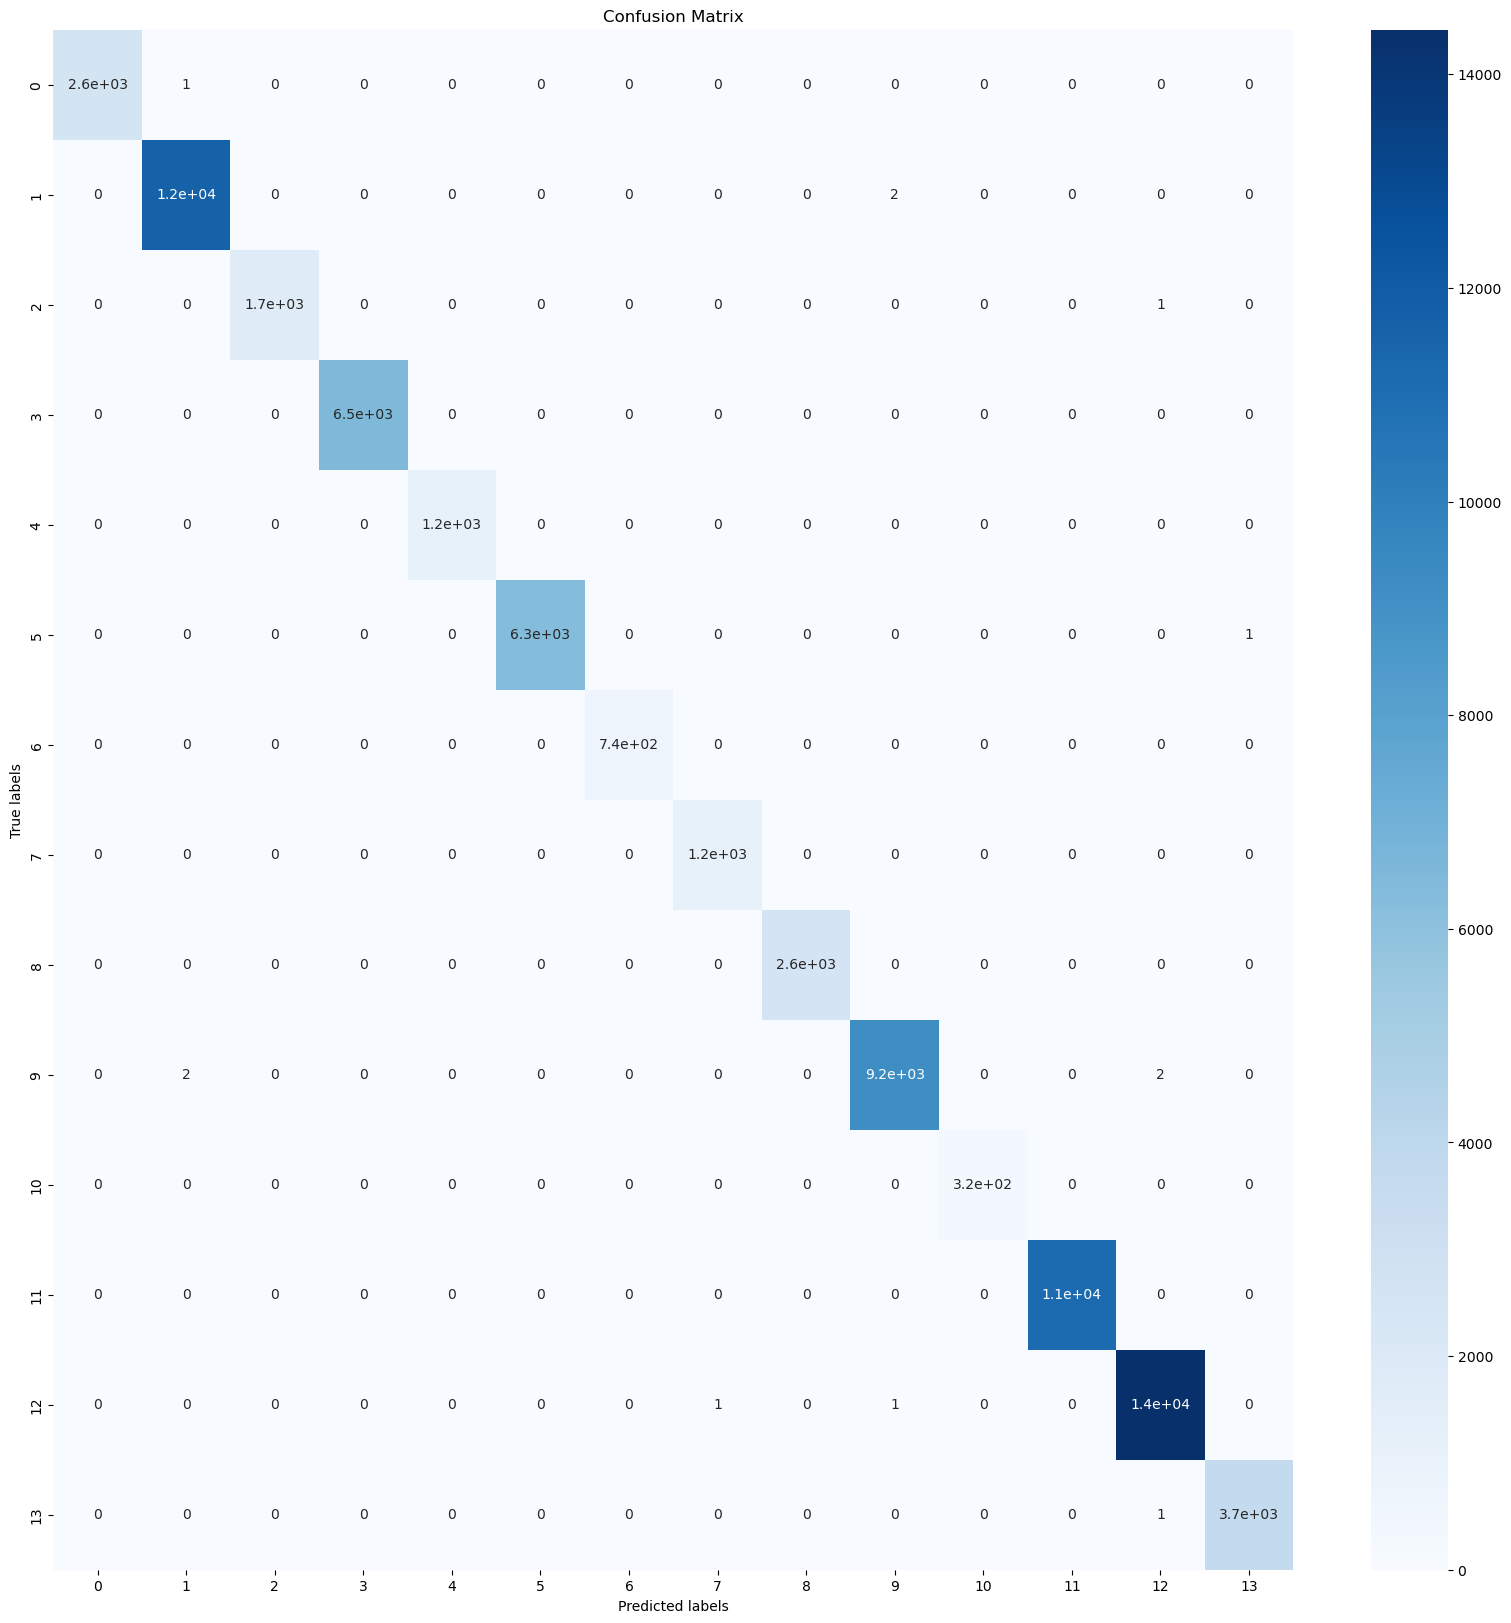

In [37]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')  # You can change the color scheme here
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### XGBoost classifier model

In [38]:
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=0)

xgb_cv_scores = cross_val_score(xgb_classifier, X_train_resampled, y_train_resampled, cv=5)

print("XGBoost CV average score: {:.2f}".format(xgb_cv_scores.mean()))


XGBoost CV average score: 1.00


In [39]:
# Fit the XGBoost classifier to the resampled training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
# Predictions on the resampled training data
y_pred_resampled_xgb = xgb_classifier.predict(X_train_resampled)

# Predictions on the test data
y_pred_xgb = xgb_classifier.predict(X_test)

# Compute accuracy for the XGBoost classifier
train_accuracy_xgb = accuracy_score(y_pred_resampled_xgb, y_train_resampled)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("\nXGBoost Classifier")
print("Train Accuracy:", train_accuracy_xgb)
print("Test Accuracy:", test_accuracy_xgb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classifier
Train Accuracy: 0.9999308715215807
Test Accuracy: 0.9997132166170486

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2620
           1       1.00      1.00      1.00     11653
           2       1.00      1.00      1.00      1693
           3       1.00      1.00      1.00      6490
           4       1.00      1.00      1.00      1174
           5       1.00      1.00      1.00      6332
           6       1.00      1.00      1.00       739
           7       1.00      1.00      1.00      1152
           8       1.00      1.00      1.00      2589
           9       1.00      1.00      1.00      9226
          10       1.00      1.00      1.00       319
          11       1.00      1.00      1.00     11111
          12       1.00      1.00      1.00     14419
          13       1.00      1.00      1.00      3709

    accuracy                           1.00     73226
   macro avg       1.

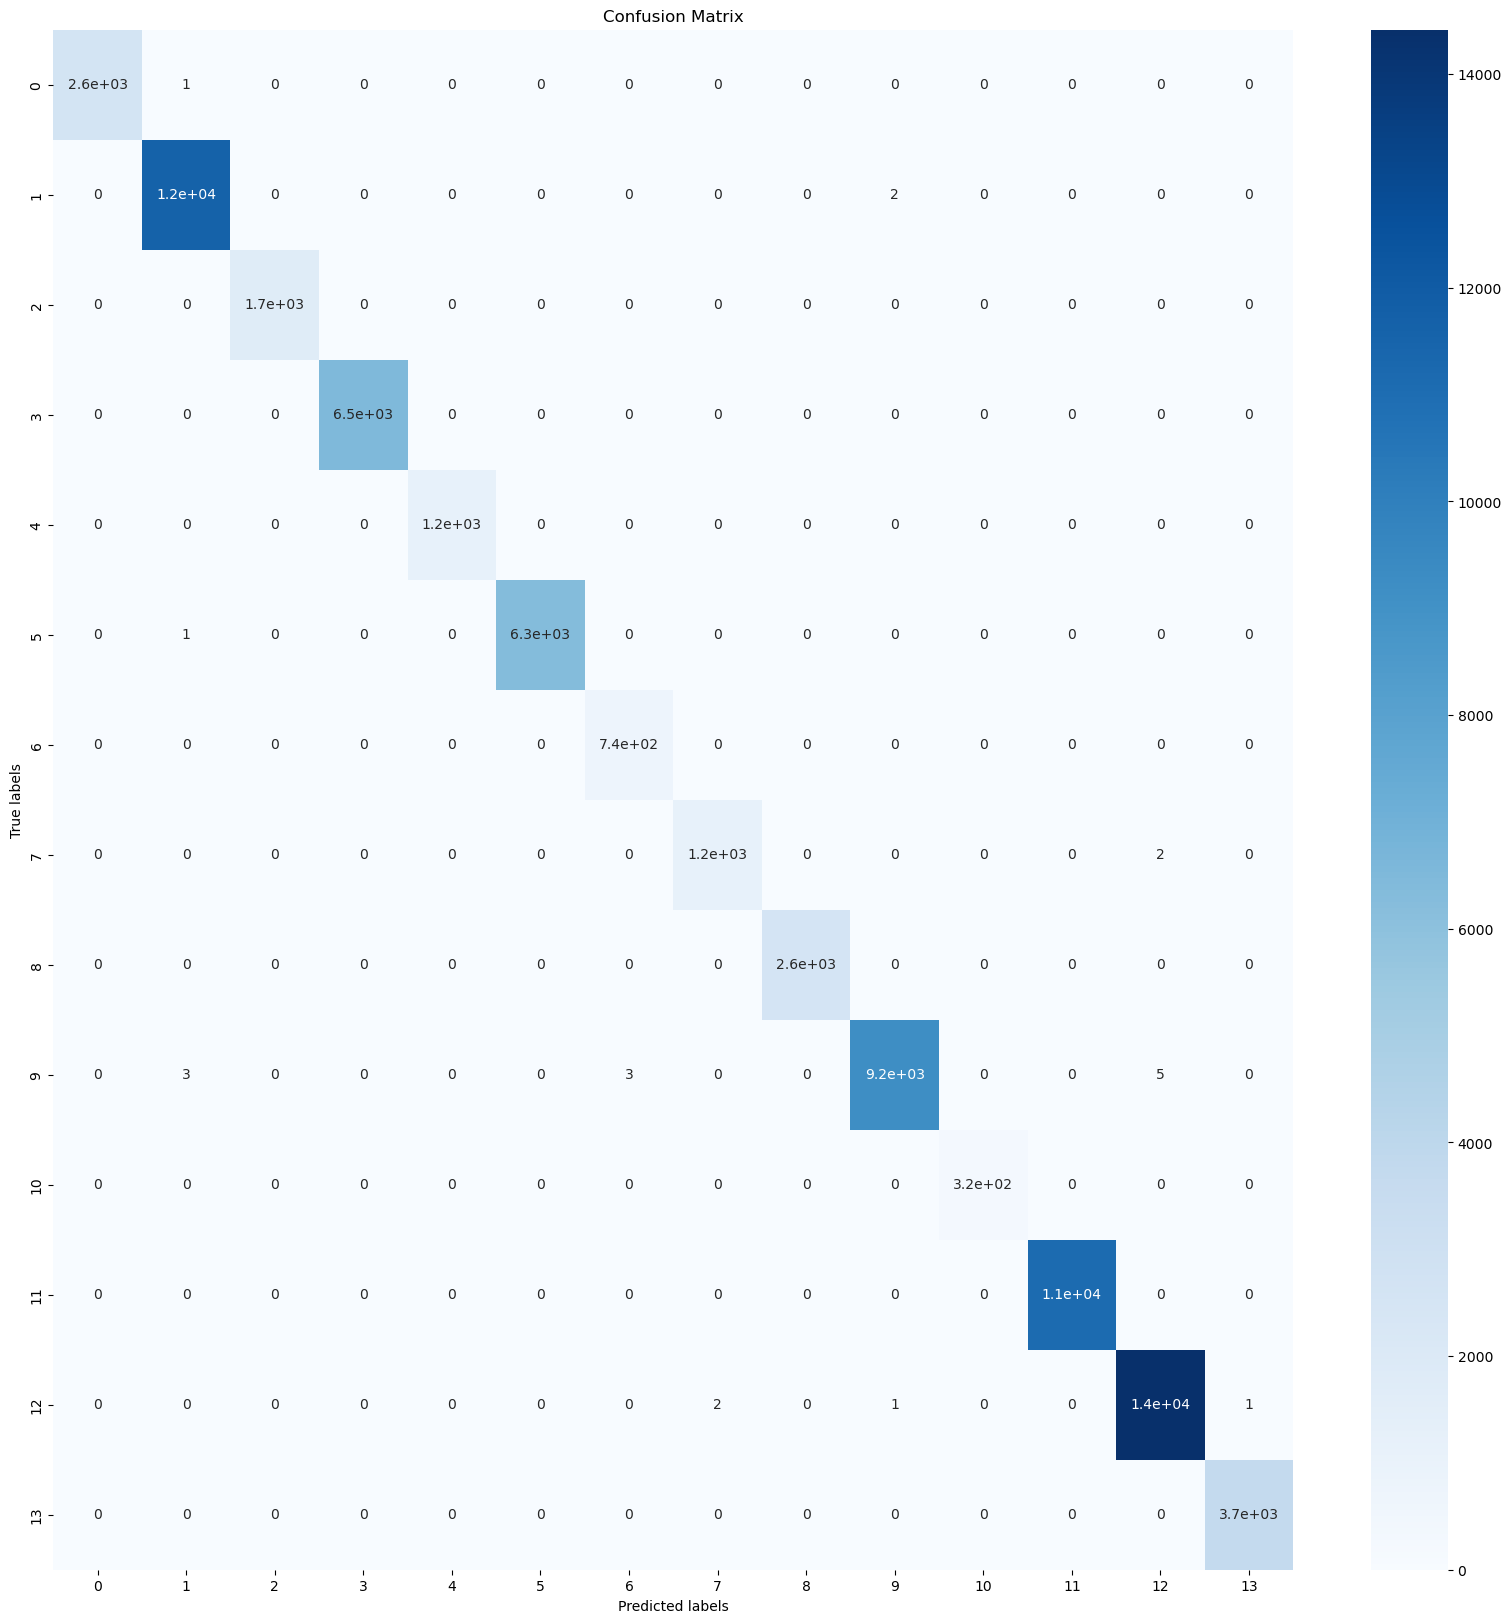

In [41]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')  # You can change the color scheme here
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
xgb_classifier.save_model("XGboost.json")

### Support vector machine model

In [43]:
# # Create a pipeline that first scales the data then applies the SVM classifier
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma="scale", max_iter=1000, random_state=0))

# # Perform cross-validation
svm_cv_scores = cross_val_score(svm_pipeline, X_train_resampled, y_train_resampled, cv=5)


C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1

In [44]:
# # Fit the SVM classifier
svm_pipeline.fit(X_train_resampled, y_train_resampled)

C:\Users\abhim\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=1000, random_state=0))])

In [45]:
# # Predictions on the resampled training data
y_pred_resampled_svm = svm_pipeline.predict(X_train_resampled)

# # Predictions on the test data
y_pred_svm = svm_pipeline.predict(X_test)

# # Compute accuracy for the SVM classifier
train_accuracy_svm = accuracy_score(y_pred_resampled_svm, y_train_resampled)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("\nSVM Classifier")
print("Cross-Validation Scores:", svm_cv_scores)
print("Mean CV Score:", svm_cv_scores.mean())
print("Train Accuracy:", train_accuracy_svm)
print("Test Accuracy:", test_accuracy_svm)
print("\nClassification Report:")
print(classification_report(y_test,y_pred_svm))


SVM Classifier
Cross-Validation Scores: [0.99742339 0.99748624 0.99631105 0.99750509 0.99771876]
Mean CV Score: 0.9972889067645359
Train Accuracy: 0.9976144390538196
Test Accuracy: 0.9955070603337612

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2620
           1       1.00      1.00      1.00     11653
           2       1.00      1.00      1.00      1693
           3       1.00      1.00      1.00      6490
           4       1.00      1.00      1.00      1174
           5       1.00      1.00      1.00      6332
           6       0.92      1.00      0.96       739
           7       0.97      1.00      0.99      1152
           8       1.00      1.00      1.00      2589
           9       1.00      0.98      0.99      9226
          10       1.00      1.00      1.00       319
          11       1.00      1.00      1.00     11111
          12       0.99      0.99      0.99     14419
          13      

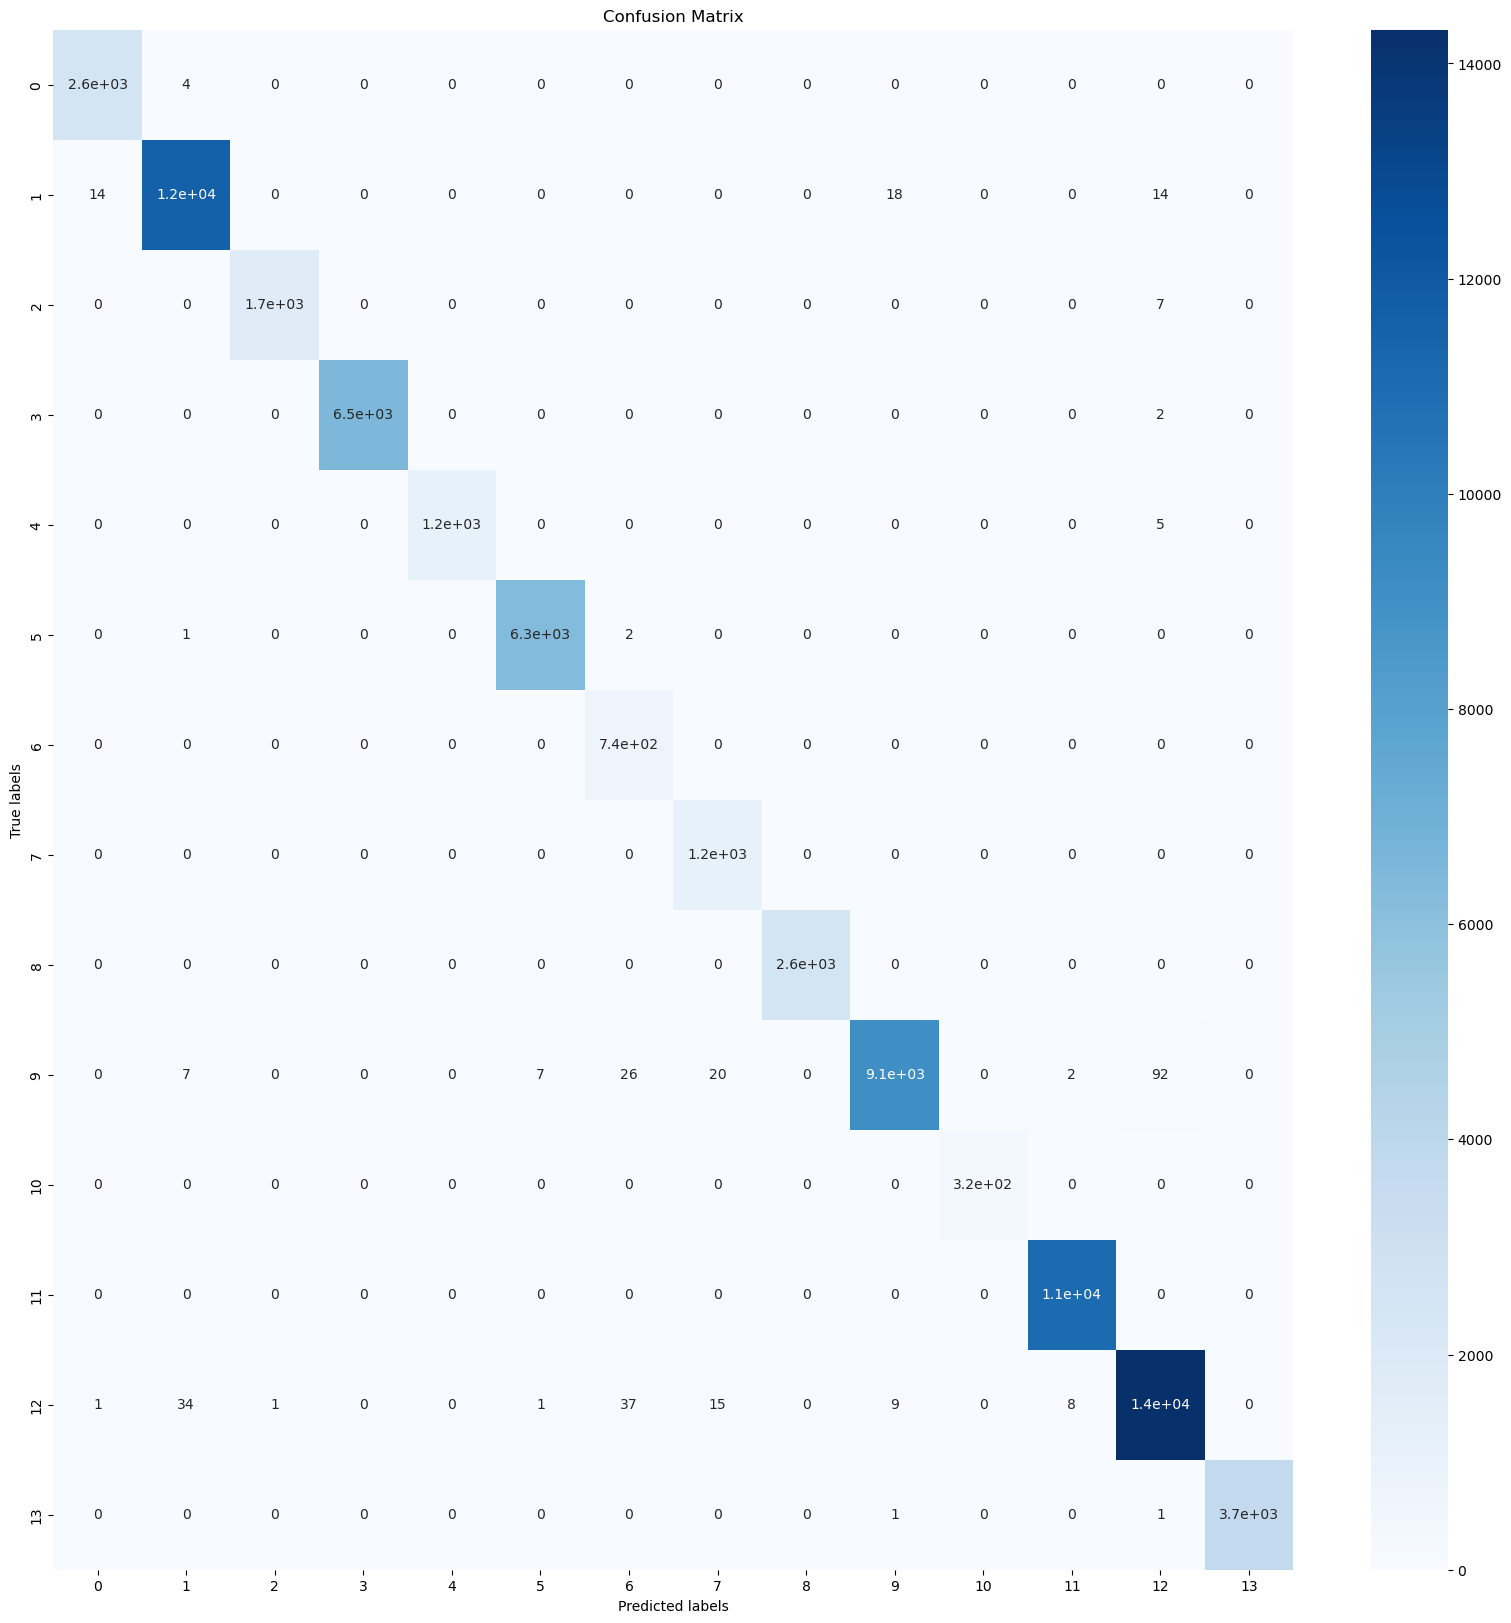

In [46]:
# # Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# # Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')  # You can change the color scheme here
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### converting into model and saving the model

In [47]:
import joblib
joblib.dump(protocol_encoder,"protocol_encoder.pkl")
joblib.dump(label_encoder,"label_encoder.pkl")
joblib.dump(dt_classifier,"dt_classifier.pkl")
joblib.dump(scaler,"scaler.pkl")
joblib.dump(xgb_classifier,"xgb_classifier.pkl")
joblib.dump(rf_classifier,"rf_classifier.pkl")
joblib.dump(svm_pipeline,"svm.pkl")

['svm.pkl']